In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
data = pd.read_csv("/kaggle/input/imdb-dataset/IMDB Dataset.csv")

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data['review'] = data['review'].apply(lambda x : x.lower())

In [5]:
import re

data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
data['review'] = data['review'].apply(lambda x: re.sub('\s+[a-zA-Z]\s+', ' ', x))
data['review'] = data['review'].apply(lambda x: re.sub('\s+', ' ', x))

In [6]:
from nltk.tokenize import word_tokenize #importing the word tokenizer
from nltk.corpus import stopwords # improting the english stopwords from nltk
stop=set(stopwords.words('english')) #creating the object as the stop in the variable

In [7]:
def create_corpus(data):
    corpus=[]
    for tweet in tqdm(data['review']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        

In [8]:
from tqdm import tqdm
#creating the corpus of the data
corpus = create_corpus(data)

100%|██████████| 50000/50000 [00:36<00:00, 1356.79it/s]


In [9]:
len(corpus)

50000

In [10]:
data['sentiment'] = data['sentiment'].replace({'positive':0,'negative':1})

In [11]:
X = corpus #creating the corpus of the data
y = data['sentiment']

In [12]:
#creating the class distribution for the label class
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,0
1,a wonderful little production br br the filmin...,0
2,i thought this was wonderful way to spend time...,0
3,basically there a family where little boy jake...,1
4,petter mattei love in the time of money is vis...,0


In [13]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,0
1,a wonderful little production br br the filmin...,0
2,i thought this was wonderful way to spend time...,0
3,basically there a family where little boy jake...,1
4,petter mattei love in the time of money is vis...,0


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer

#initializing the object for it
#it is important to note that whenever you are trying to convert the preprocessing data which is converted into the list
#the tfidf creates a problem becuase of the lower character tranformation and which cannot be done in the list object.
#due to which it has to turned off , then only you can move further and then obtaining the sparse matrix
tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False)

In [15]:
transform = tfidf.fit_transform(corpus)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train ,X_test,y_train,y_test = train_test_split(transform,y,test_size=0.2,random_state=42,shuffle=True)

# XGBoost

In [18]:
import xgboost as xgb #importing the xgboost classifier
#intiating the object of the xgboost classifier
# fit model no training data
from numpy import loadtxt
from xgboost import XGBClassifier
model = XGBClassifier()
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)


In [19]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [53]:
#doing the prediction on the dataset
y_pred = model.predict(X_test)
#loading the important classess in the dataset
from sklearn.metrics import accuracy_score
#finding out the accuracy score of the given datset 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.71%


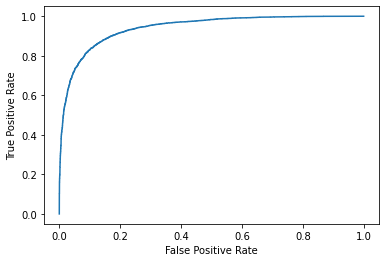

In [54]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
#calcualting the f1 score of the following model
from sklearn.metrics import f1_score ,classification_report
#calcuating the score
print(f1_score(y_test,y_pred))
#printing the classification score of the dataset
print(classification_report(y_test,y_pred))

0.8679845038243766
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      5039
           1       0.86      0.88      0.87      4961

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# **Random Forest

In [22]:
#importing the random forest module in the library
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random = RandomForestClassifier()
#defining the parameters
parameters = {
    'n_estimators':[5,20,30],
    'max_depth':[2,10,20,None]
}

In [23]:
cv = GridSearchCV(random,parameters,cv=10)
#using the hyperparameters tuning in them
cv.fit(X_train , y_train)
#printing the results of the cross validation
#print_results(cv)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 10, 20, None],
                         'n_estimators': [5, 20, 30]})

In [24]:
cv.best_estimator_

RandomForestClassifier(n_estimators=30)

In [25]:
#cv.best_score(X_test,y_test)
cv.best_score_

0.8313750000000001

In [26]:
cv.best_params_

{'max_depth': None, 'n_estimators': 30}

so after using the cross validation on the training data, we still do not the got the score that we were reqiring and got the less score than the other models that we are using the XGBoost and the Naive bayes.

# **Naive Bayes

In [27]:
#naive bayes if the probabilistic approach that is taken where the prediction are taken from the probabilistic distribution 
#it also comes under the part of bayesian statistics.
from sklearn.naive_bayes import MultinomialNB
#how to import metrics
from sklearn import metrics

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [28]:
model.score(X_test,y_test)

0.8671

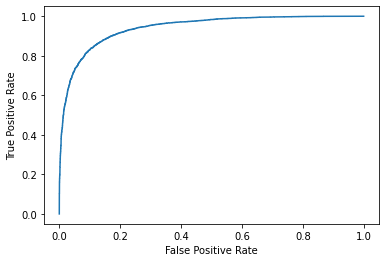

In [29]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Unsupervised learning 
1. K nearest neighbors 

In [30]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

In [31]:
knn_model.fit(X_train,y_train)

KNeighborsRegressor()

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#creating out the prediction values in the dataset
predicted_values = knn_model.predict(X_train)
mse = mean_squared_error(y_train,predicted_values)
#in order to calcualate the rmse of the values in the dataset we need to make the square root of the mean squared error
rmse = sqrt(mse)

print(rmse)

0.3251584229264252


# Bernoulli Naive Bayes algorithm

Where we have to make the posterior distribution with help of the function and also to maximize the likelihood function in order to make the better prediction

In [38]:
from sklearn.naive_bayes import BernoulliNB
#creating the object for the naive bayers theorem
from sklearn.metrics import accuracy_score
#finding the accuracy score of the model
clf = BernoulliNB()
#fitting the model to the dataset
clf.fit(X_train,y_train)
#printing the model score from the dataset
print(clf.score(X_test,y_test))

0.8527


In [39]:
y_pred =clf.predict(X_test)
#accuracy score
accuracy_score = accuracy_score(y_test,y_pred)
print(accuracy_score)

0.8527


# Support Vector Machine

In [59]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [60]:
#importing the svm model 
from sklearn import svm
#creating the object from the dataset
model_svm = svm.SVC()

In [61]:
print(model_svm)

SVC()


In [62]:
grid_svm = GridSearchCV(model_svm,param_grid,n_jobs=-1, refit = True, verbose = 3)

In [ ]:
#fitting the model to the cataset
grid_svm_fitted = grid_svm.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
#printing the best parameters 
print(grid_svm_fitted.best_params_)

In [ ]:
#printing the best estimators
print(grid_svm_fitted.best_estimator_)